In [109]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sldata import SessionData
from scipy.signal import find_peaks

In [133]:
mouse_id = "7011"
session_id = "m5"
experiment = "clickbait-motivate"
base_path = "D:/data/"
cluster = 26

In [134]:
data = SessionData(
    mouse_id=mouse_id,
    session_id=session_id,
    experiment=experiment,
    base_path=base_path,
    min_spikes=50,
    verbose=True)

Successfully loaded spike_times from D:\data\clickbait-motivate\kilosorted\7011\m5\spike_times.npy
Successfully loaded spike_templates from D:\data\clickbait-motivate\kilosorted\7011\m5\spike_templates.npy
Successfully loaded templates from D:\data\clickbait-motivate\kilosorted\7011\m5\templates.npy
Successfully loaded sniff from D:\data\clickbait-motivate\preprocessed\7011\m5\sniff.npy
Loaded data: ['spike_times', 'spike_templates', 'templates', 'sniff']
Successfully loaded events from D:\data\clickbait-motivate\events\7011\m5\events.csv
Video properties: 888x1968, 30.0 FPS, 81840 frames
Loaded cluster labels: 17 good, 0 mua, 53 noise
Excluded 53 noise clusters
Found 19655 peaks in sniff signal
Peak times range: 1.5 - 91611.5 ms
Loaded 23 clusters for 7011_m5
Loaded sniff data: 2748440 samples
Found 19655 sniff events


In [147]:
data.clusters[18]

{'cluster_id': 26,
 'label': 'good',
 'best_channel': np.int64(14),
 'spike_times': array([   2786.03333333,    3023.13333333,    3192.03333333, ...,
        2747596.33333333, 2747607.86666667, 2748127.76666667],
       shape=(11990,)),
 'waveform_template': array([  0.1826993 ,   0.20059115,   0.2243931 ,   0.2612242 ,
          0.3292036 ,   0.4598623 ,   0.5643398 ,   0.63345903,
          0.84508   ,   1.4903837 ,   2.7028248 ,   3.8588772 ,
          3.7760584 ,   2.2173548 ,   0.3821085 ,  -0.29497474,
         -0.04329689,  -1.2084124 ,  -5.980461  , -12.397028  ,
        -15.636007  , -12.304069  ,  -4.531132  ,   2.4453692 ,
          5.756004  ,   5.7238927 ,   4.41428   ,   3.3591022 ,
          2.7255368 ,   2.1806536 ,   1.5811766 ,   1.0504678 ,
          0.7136443 ,   0.52266145,   0.4113985 ,   0.32651538,
          0.2863442 ,   0.26232398,   0.22090167,   0.18281372,
          0.1590341 ,   0.17083076,   0.1757938 ,   0.15449908,
          0.10946112,   0.0798087 ,   

In [154]:
for idx in range(len(data.clusters)):
    if data.clusters[idx]['cluster_id'] == cluster:
        cluster = idx
        break

In [156]:
# Get LFP on best channel of the specified cluster
cluster_id = data.clusters[cluster]['cluster_id']
best_channel = data.clusters[cluster]['best_channel']
lfp = np.load(f"{base_path}{experiment}/preprocessed/{mouse_id}/{session_id}/lfp.npy")
theta = lfp[best_channel,:]
sos = signal.butter(3, 8, 'low', fs=1000, output='sos')  # 8 Hz lowpass filter
theta = signal.sosfiltfilt(sos, theta)

In [159]:
# Find peaks in the theta array
peaks, _ = find_peaks(theta)

# Find troughs in the theta array by finding peaks of the negative theta
troughs, _ = find_peaks(-theta)

In [160]:
# Get spikes and convert to seconds
spikes = data.clusters[cluster]['spike_times']

In [161]:
print(len(spikes))
print(np.mean(spikes))

11990
1378857.2515123712


In [162]:
print(len(peaks))
print(len(troughs))
print(peaks[0])
print(troughs[0])

14471
14470
87
164


In [163]:
def assign_phase_by_cycles(signal, peaks, troughs):
    """
    Assign phase by identifying complete cycles (peak-trough-peak).
    """
    phase = np.full_like(signal, np.nan, dtype=float)
    
    if peaks[0] > troughs[0]:
        troughs = troughs[1:]

    # Process each peak-to-peak cycle
    for i in range(len(peaks) - 1):
        peak = peaks[i]
        trough = troughs[i]

        # Ascending phase: peak to trough (0 to π)
        ascending_samples = trough - peak
        phase[peak:trough] = np.linspace(0, np.pi, ascending_samples)
        
        # Descending phase: trough to next peak (π to 2π)
        descending_samples = peaks[i+1] - trough
        phase[trough:peaks[i+1]] = np.linspace(np.pi, 2*np.pi, descending_samples)
    
    return phase

In [168]:
phase = assign_phase_by_cycles(theta, peaks, troughs)

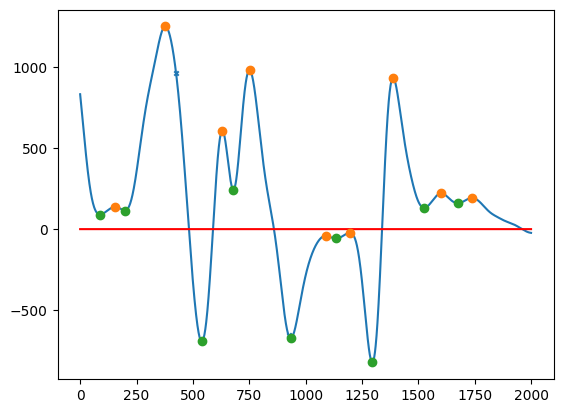

In [169]:
start = 100000 
window = 2000
end = start + window

spike_mask = (spikes >= start) & (spikes <= end)
plot_spikes = spikes[spike_mask]
plot_spikes = np.array([int(x) for x in plot_spikes], dtype=np.int32)

peak_mask = (peaks >= start) & (peaks <= end)
plot_peaks = peaks[peak_mask]

trough_mask = (troughs >= start) & (troughs <= end)
plot_troughs = troughs[trough_mask]

plt.plot(theta[start:end])
plt.plot(phase[start:end]/100, color='red')
plt.scatter(plot_spikes-start, theta[plot_spikes], zorder=5, marker='x', s=10)
plt.scatter(plot_peaks-start, theta[plot_peaks], zorder=5)
plt.scatter(plot_troughs-start, theta[plot_troughs], zorder=5)

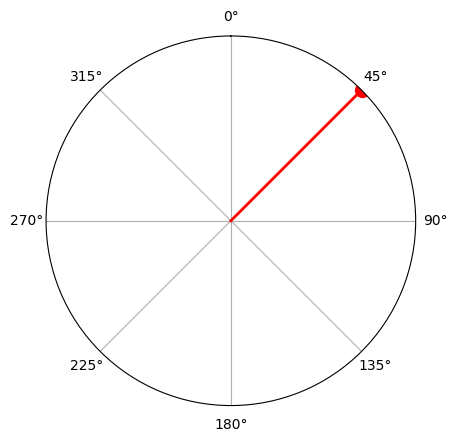

In [121]:
# Create figure and polar axis
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Define the angle (in radians)
angle = np.pi/4  # 45 degrees as example

# Plot a line from center to edge at this angle
# The line goes from radius 0 to radius 1
ax.plot([angle, angle], [0, 1], 'r-', linewidth=2)

# Optional: Add a marker at the end
ax.plot(angle, 1, 'ro', markersize=10)

# Optional customizations
ax.set_ylim(0, 1)  # Set radial limits
ax.set_theta_zero_location('N')  # Set 0° to top (North)
ax.set_theta_direction(-1)  # Clockwise
ax.set_yticks([]) 
#ax.grid(False)  

plt.show()

In [122]:
from scipy import signal

In [123]:
# Pxx_spec: power spectral density or power spectrum (depending on scaling)
f, Pxx_spec = signal.welch(theta, 1000, 'flattop', 1024, scaling='spectrum')

In [124]:
max(Pxx_spec)

np.float64(138126.25611638956)